In [1]:
import math
import numpy as np
from numpy.random import default_rng

import scipy
from scipy.stats import qmc
from smt.sampling_methods import LHS

from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import PCA

import time
import os
%matplotlib inline 
font = {'size'   : 30}
matplotlib.rc('font', **font)
cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2))

# seeds
np.random.seed(125)
rng = default_rng(125)

In [2]:
def pad_arrays_with_last_value(arr_list):
    """
    Takes a list of 1D numpy arrays of varying lengths,
    pads each array to the length of the longest array using the last value,
    and returns a 2D numpy array with each row as a padded array.
    """
    max_len = max(len(arr) for arr in arr_list)
    padded_array = np.zeros((len(arr_list), max_len))

    for i, arr in enumerate(arr_list):
        fill_len = max_len - len(arr)
        if fill_len > 0:
            pad_value = arr[-1]
            padded_arr = np.concatenate([arr, np.full(fill_len, pad_value)])
        else:
            padded_arr = arr
        padded_array[i, :] = padded_arr

    return padded_array

In [3]:
total_data  = [np.load('data/'+str(i)+'/ALAEmGP-Borehole-testrmse.npy') for i in range(10)]
rtotal_data = [np.load('data/'+str(i)+'/rALAEmGP-Borehole-testrmse.npy') for i in range(10)]

In [4]:
plot_data = pad_arrays_with_last_value(total_data)
plot_range = range(plot_data.shape[1])
plot_mean = plot_data.mean(axis=0)
plot_std = plot_data.std(axis=0)
rplot_data = pad_arrays_with_last_value(rtotal_data)
rplot_range = range(rplot_data.shape[1])
rplot_mean = rplot_data.mean(axis=0)
rplot_std = rplot_data.std(axis=0)

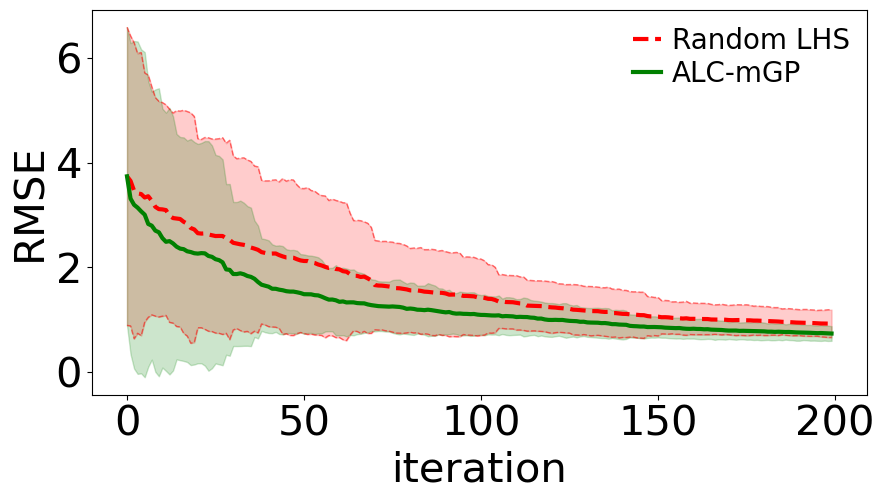

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# green predicted line
ax.plot(rplot_range, rplot_mean, linewidth=3, label='Random LHS', linestyle='--', c='red')

# green fill + dotted boundary
ax.fill_between(rplot_range, rplot_mean - 1.96 * rplot_std, rplot_mean + 1.96 * rplot_std,
                alpha=0.2, color='red')

# manually plot the boundaries with dotted lines
ax.plot(rplot_range, rplot_mean - 1.96 * rplot_std, linestyle='--', alpha = 0.5, color='red', linewidth=1)
ax.plot(rplot_range, rplot_mean + 1.96 * rplot_std, linestyle='--', alpha = 0.5, color='red', linewidth=1)

# red predicted line
ax.plot(plot_range, plot_mean, linewidth=3, label='ALC-mGP', c='green')

# red fill (no boundary)
ax.fill_between(plot_range, plot_mean - 1.96 * plot_std, plot_mean + 1.96 * plot_std,
                alpha=0.2, color='green')

legend = ax.legend(    
    loc='upper right',
    fontsize=20,          # 缩小文字
    markerscale=1,        # 缩小图例中 marker 的缩放
    handlelength=1.0,     # 缩短图例线条
    handletextpad=0.4,    # 图形和文字之间的间隔
    labelspacing=0.2,     # 不同行之间的垂直间隔
    borderpad=0.3,        # 图例边框与内容的间隔
    borderaxespad=0.3,    # 图例边框与主图之间的间距)
)
legend.get_frame().set_linewidth(0)  # 无边框线宽
legend.get_frame().set_edgecolor('none')  # 无边框颜色
legend.get_frame().set_facecolor('none')  # 无背景色（透明）

ax.set_xlabel('iteration')
ax.set_ylabel('RMSE')
plt.savefig('ALAEmGP-Borehole-RMSE-shades.pdf', format='pdf', bbox_inches='tight')
plt.show()

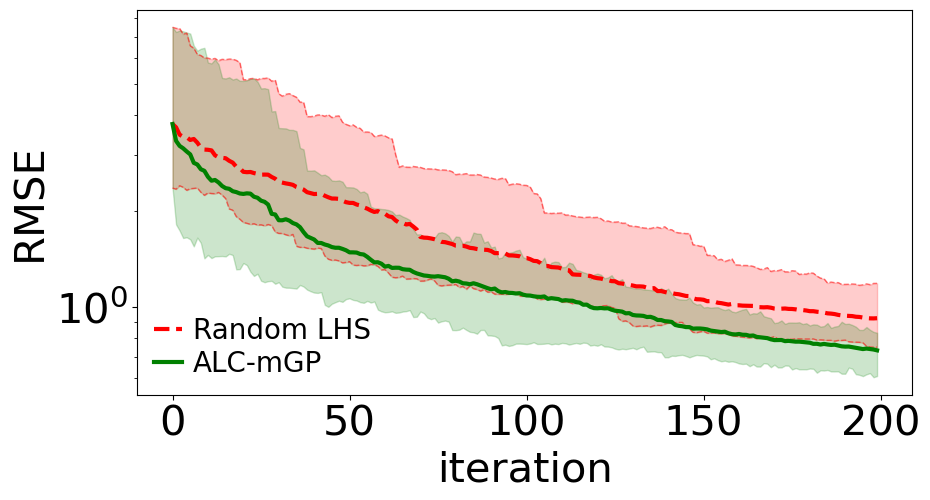

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# green predicted line
ax.plot(rplot_range, rplot_mean, linewidth=3, label='Random LHS', linestyle='--', c='red')

# green fill + dotted boundary
ax.fill_between(rplot_range, np.array(rtotal_data).min(axis=0), np.array(rtotal_data).max(axis=0),
                alpha=0.2, color='red')

# manually plot the boundaries with dotted lines
ax.plot(rplot_range, np.array(rtotal_data).min(axis=0), linestyle='--', alpha = 0.5, color='red', linewidth=1)
ax.plot(rplot_range, np.array(rtotal_data).max(axis=0), linestyle='--', alpha = 0.5, color='red', linewidth=1)

# red predicted line
ax.plot(plot_range, plot_mean, linewidth=3, label='ALC-mGP', c='green')

# red fill (no boundary)
ax.fill_between(plot_range, np.array(total_data).min(axis=0), np.array(total_data).max(axis=0),
                alpha=0.2, color='green')

ax.set_yscale('log')


legend = ax.legend(    
    loc='lower left',
    fontsize=20,          # 缩小文字
    markerscale=1,        # 缩小图例中 marker 的缩放
    handlelength=1.0,     # 缩短图例线条
    handletextpad=0.4,    # 图形和文字之间的间隔
    labelspacing=0.2,     # 不同行之间的垂直间隔
    borderpad=0.3,        # 图例边框与内容的间隔
    borderaxespad=0.3,    # 图例边框与主图之间的间距)
)
legend.get_frame().set_linewidth(0)  # 无边框线宽
legend.get_frame().set_edgecolor('none')  # 无边框颜色
legend.get_frame().set_facecolor('none')  # 无背景色（透明）

ax.set_xlabel('iteration')
ax.set_ylabel('RMSE')
plt.savefig('ALAEmGP-Borehole-RMSE-shades-minmax.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [7]:
np.min(total_data)

np.float64(0.6048890352249146)

In [13]:
# Re-import required libraries after code execution environment reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

# Borehole function
def f(x_zeroOne):
    l_bounds = np.array([0.05, 100, 63070, 990, 63.1, 700, 1120, 9855])
    u_bounds = np.array([0.15, 50000, 115600, 1110, 116, 820, 1680, 12045])
    x_physical = l_bounds + x_zeroOne * (u_bounds - l_bounds)

    r_w = x_physical[:, 0]
    r   = x_physical[:, 1]
    T_u = x_physical[:, 2]
    H_u = x_physical[:, 3]
    T_l = x_physical[:, 4]
    H_l = x_physical[:, 5]
    L   = x_physical[:, 6]
    K_w = x_physical[:, 7]

    numerator = 2 * np.pi * T_u * (H_u - H_l)
    log_rrw = np.log(r / r_w)
    denominator = log_rrw * (1 + 2 * L * T_u / (log_rrw * r_w**2 * K_w) + T_u / T_l)
    y = numerator / denominator
    return y.reshape(-1, 1).astype(np.float32)

# Sample 10,000 points in [0, 1]^8
sampler = qmc.LatinHypercube(d=8, seed=42)
x_sample = sampler.random(n=10000)
y_sample = f(x_sample)
# Compute percentiles
p10 = np.percentile(y_sample, 10)
p90 = np.percentile(y_sample, 90)

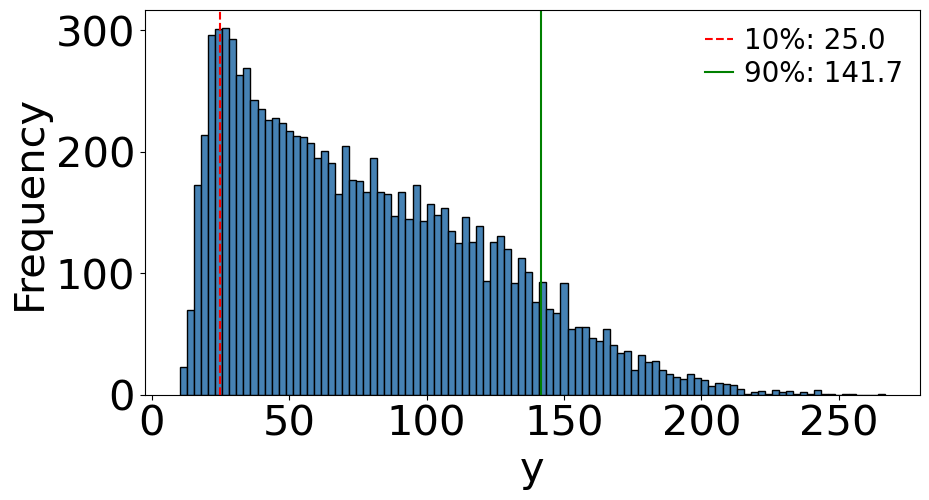

<Figure size 640x480 with 0 Axes>

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.set_xlabel('y')
ax.set_ylabel('Frequency')
plt.hist(y_sample, bins=100, color='steelblue', edgecolor='black')
# Add vertical lines and annotations
ax.axvline(p10, color='red', linestyle='--', label=f'10%: {p10:.1f}')
ax.axvline(p90, color='green', label=f'90%: {p90:.1f}')

legend = ax.legend(    
    loc='upper right',
    fontsize=20,          # 缩小文字
    markerscale=1,        # 缩小图例中 marker 的缩放
    handlelength=1.0,     # 缩短图例线条
    handletextpad=0.4,    # 图形和文字之间的间隔
    labelspacing=0.2,     # 不同行之间的垂直间隔
    borderpad=0.3,        # 图例边框与内容的间隔
    borderaxespad=0.3,    # 图例边框与主图之间的间距)
)
legend.get_frame().set_linewidth(0)  # 无边框线宽
legend.get_frame().set_edgecolor('none')  # 无边框颜色
legend.get_frame().set_facecolor('none')  # 无背景色（透明）

plt.show()
plt.savefig('Borehole-histogram.pdf', format='pdf', bbox_inches='tight')